### 8.1.2 训练


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


C:\Users\25466\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


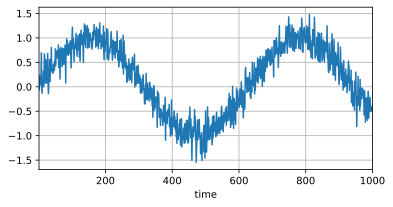

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', xlim=[1, 1000], figsize=(6, 3))


In [22]:
tau = 4
features = torch.zeros((T - tau, tau))  # 1000 - 4 , 4
print(f'x[0:10] : {x[0:10]}')
for i in range(tau):
    features[:, i] = x[i: T - tau + i]  # x[(0,996), (1,997), (2,998), (3,999)]
    # features ~ [[x_t0, x_t1, x_t2, x_t3], [x_t1, x_t2, x_t3, x_t4]...]; labels ~ [x_t4, x_t5, x_t6...]
    print(f'features: {features}')
labels = x[tau:].reshape((-1, 1))
print(labels.shape)


x[0:10] : tensor([ 0.0949, -0.0622,  0.2265,  0.0305,  0.1029,  0.0583,  0.2071,  0.6948,
         0.0533, -0.1306])
features: tensor([[ 0.0949,  0.0000,  0.0000,  0.0000],
        [-0.0622,  0.0000,  0.0000,  0.0000],
        [ 0.2265,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.5068,  0.0000,  0.0000,  0.0000],
        [-0.4450,  0.0000,  0.0000,  0.0000],
        [-0.4984,  0.0000,  0.0000,  0.0000]])
features: tensor([[ 0.0949, -0.0622,  0.0000,  0.0000],
        [-0.0622,  0.2265,  0.0000,  0.0000],
        [ 0.2265,  0.0305,  0.0000,  0.0000],
        ...,
        [-0.5068, -0.4450,  0.0000,  0.0000],
        [-0.4450, -0.4984,  0.0000,  0.0000],
        [-0.4984, -0.4047,  0.0000,  0.0000]])
features: tensor([[ 0.0949, -0.0622,  0.2265,  0.0000],
        [-0.0622,  0.2265,  0.0305,  0.0000],
        [ 0.2265,  0.0305,  0.1029,  0.0000],
        ...,
        [-0.5068, -0.4450, -0.4984,  0.0000],
        [-0.4450, -0.4984, -0.4047,  0.0000],
        [-0.4984, -0.4047, -0.

In [5]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array(
    (features[:n_train], labels[:n_train]), batch_size, is_train=True)


In [14]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机


def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net


# 平方损失，注意MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')


In [16]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(
            f'epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)


epoch 1, loss: 0.057191
epoch 2, loss: 0.053104
epoch 3, loss: 0.048550
epoch 4, loss: 0.047991
epoch 5, loss: 0.046687


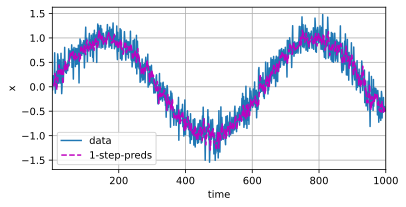

In [23]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy(
)], 'time', 'x', legend=['data', '1-step-preds'], xlim=[1, 1000], figsize=(6, 3))  # (time, x.detach().numpy()), (time[tau:], onestep_preds.detach().numpy())分别为2组数据


In [24]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau: i]).reshape((1, -1))


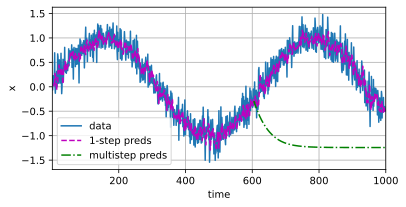

In [28]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1, 1000], figsize=[6, 3])


## 8.2 文本预处理


In [2]:
import collections
import re
from d2l import torch as d2l


C:\Users\25466\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


### 8.2.1 读取数据集


In [3]:
d2l.DATA_HUB['time_machine'] = (
    d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')


def read_time_machine():
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip() for line in lines]


lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])


# 文本总行数: 3221
The Time Machine by H G Wells
twinkled and his usually pale face was flushed and animated The


In [4]:
def tokenize(lines, token='word'):
    """将文本拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误: 未知词元类型: ' + token)


tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])


['The', 'Time', 'Machine', 'by', 'H', 'G', 'Wells']
[]
[]
[]
[]
['I']
[]
[]
['The', 'Time', 'Traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'His', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'The']


In [8]:
class Vocab:
    """文本词表"""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(
            counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx,
                             token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)  # 按词元频率由高到低存储词元
                self.token_to_idx[token] = len(
                    self.idx_to_token) - 1  # 存储(token: idx)键值对

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token.get[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


In [9]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])


[('<unk>', 0), ('the', 1), ('I', 2), ('of', 3), ('and', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('my', 9)]


In [10]:
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，
    # 所以将所有⽂本⾏展平到⼀个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)


(170580, 53)

### 8.3.3 自然语言统计


In [11]:
import random
import torch
from d2l import torch as d2l


In [12]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]


[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

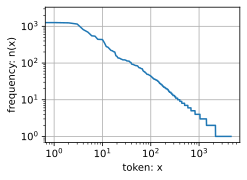

In [13]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')


In [22]:
# (1,2), (2,3), (3,4),...依次错开构成词对
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]


[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

### 8.3.4 读取长序列数据


In [26]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量序列"""
    # 从随机偏移量开始对序列进行分区，随即范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps  # 注意 Y 的起始索引相比 X 向后移动一位
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        # 取打乱顺序（shuffle）后连续的batch_size组数据
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


In [33]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[17, 18, 19, 20, 21],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [23, 24, 25, 26, 27]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [13, 14, 15, 16, 17]])
X:  tensor([[ 2,  3,  4,  5,  6],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [28, 29, 30, 31, 32]])


In [25]:
for i in range(0, 10, 2):
    print(i)


0
2
4
6
8


### 8.4.1 有隐状态的循环神经网络


In [34]:
import torch
from d2l import torch as d2l


In [35]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)


tensor([[ 1.6691, -2.6481, -1.7281, -3.1768],
        [-0.2964,  1.9861,  1.0748,  1.3533],
        [ 1.7262, -3.7971, -2.4302, -3.1360]])

## 8.5 循环神经网络的从零开始实现


In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


C:\Users\25466\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
batch_size, num_Steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_Steps)


In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))  # 词元类型为 char, 长度为 28
len(vocab)


28

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape


torch.Size([5, 2, 28])

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.1
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
    

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )


In [7]:
def rnn(inputs, state, params):
    # inputs的形状：（时间步数量，批量大小，词表大小）
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：（批量大小，词表大小）
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)


In [8]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""

    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)


In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape


(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]

    def get_input(): return torch.tensor(
        [outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())


'time traveller k ygkndbej'

In [12]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        # params = [0: W_xh, 1: W_hh, 2: b_h, 3: W_hq, 4: b_q]
        params = net.params
    # Y = f(H, W_hq(3), b_q(4)), H = g(X, W_xh(0), H, W_hh(1), b_h(2))
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    # 梯度：Y.grad = (∂Y/∂W_xh, ∂Y/∂W_hh, ∂Y/∂b_h, ∂Y/∂W_hq, ∂Y/∂b_q,)
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


### 8.5.6 分离梯度


In [13]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和，词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()


In [14]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=[
                            'train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        def updater(batch_size): return d2l.sgd(net.params, lr, batch_size)

    def predict(prefix): return predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


困惑度 15.2, 44796.8 词元/秒 cuda:0
time traveller angendin antendin aneetisis onetitime ansetimen d
travelleris maneethinn santethin andetis m anethidin anseni


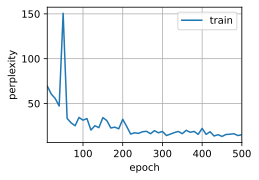

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())


困惑度 13.0, 54635.9 词元/秒 cuda:0
time travellere the t an  he and inst and an  an then the in t a
traveller t t t ann the t is ant and an t an the and the t 


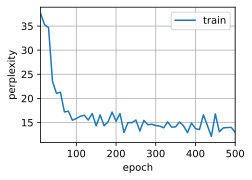

In [16]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)


### 8.6 循环神经网络的简洁实现


In [17]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


### 8.6.1 定义模型


In [19]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)


In [20]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape


torch.Size([1, 32, 256])

In [22]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape


(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [28]:
class RNNModel(nn.Module):
    """循环神经网络模型"""

    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的，num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层将首先将Y的形状改为（时间步数*批量大小， 隐藏单元数）
        # 它的输出形状是（时间步数*批量大小，词表大小）
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (
                torch.zeros(
                    (self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device),
                torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device))


In [29]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellertjtjtjtjtj'

perplexity 1.3, 179200.2 tokens/sec on cuda:0
time traveller proune brecoonthof tha four dimensioned wint we c
traveller proune bur allicuthe rimetserreally it the lime a


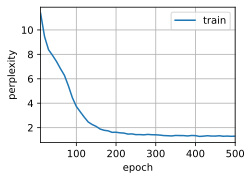

In [30]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)